In [1]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [2]:
LEVERAGE = 10
INITIAL_CAP = 200000

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [3]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [5]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
# df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df.head()

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055,0.08,0.000003
1,2014-01-03,30.035,0.08,0.000003
2,2014-01-06,30.160,0.08,0.000003
3,2014-01-07,30.260,0.07,0.000003
4,2014-01-08,30.150,0.07,0.000003


In [6]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * LEVERAGE
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                           0.09
Daily_EFFR                                 0.000004
Daily_return                               0.005885
Daily_excess_return                        0.005881
Daily_excess_leverage_return               0.058814
Name: 196, dtype: object

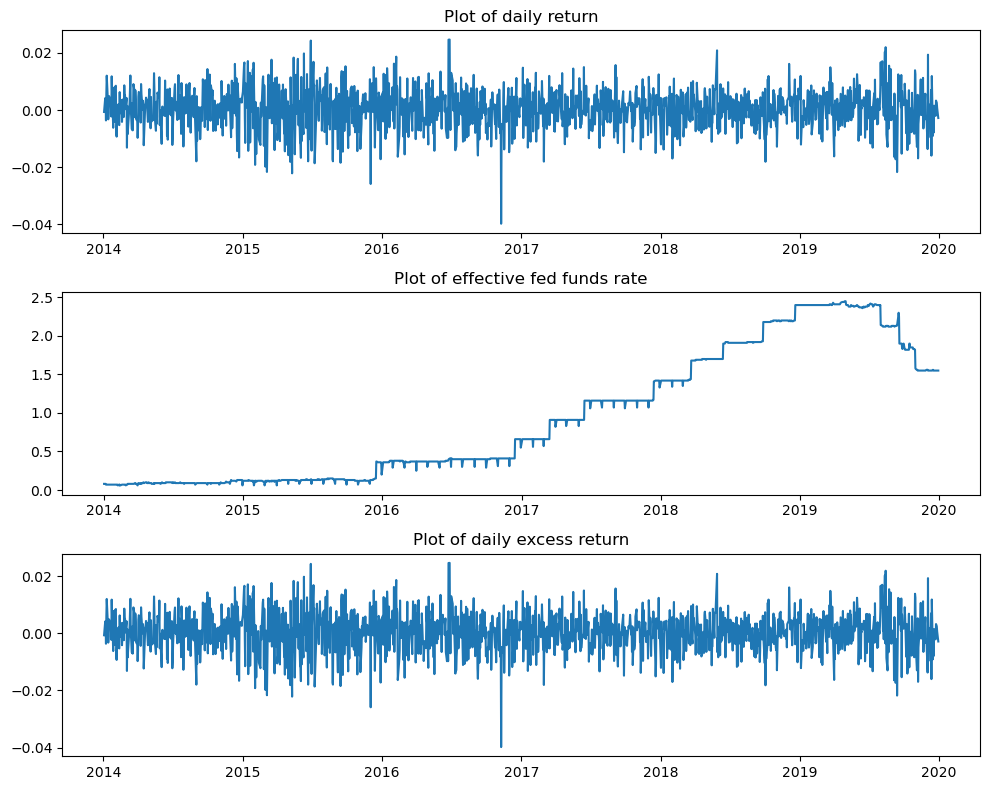

In [7]:
fig, ax = plt.subplots(3, 1, figsize = (10, 8))

ax[0].plot(df['Date'], df['Daily_return'])
ax[0].set_title('Plot of daily return')
ax[1].plot(df['Date'], df['EFFR'])
ax[1].set_title('Plot of effective fed funds rate')
ax[2].plot(df['Date'], df['Daily_excess_return'])
ax[2].set_title('Plot of daily excess return')
plt.tight_layout()

In [8]:
df

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return
0,2014-01-02,30.055000,0.08,0.000003,NaN,NaN,NaN
1,2014-01-03,30.035000,0.08,0.000003,-0.000665,-0.000669,-0.006686
2,2014-01-06,30.160000,0.08,0.000003,0.004162,0.004159,0.041586
3,2014-01-07,30.260000,0.07,0.000003,0.003316,0.003313,0.033129
4,2014-01-08,30.150000,0.07,0.000003,-0.003635,-0.003638,-0.036380
...,...,...,...,...,...,...,...
1504,2019-12-23,39.160000,1.55,0.000062,-0.002039,-0.002100,-0.021003
1505,2019-12-24,39.290001,1.55,0.000062,0.003320,0.003258,0.032582
1506,2019-12-26,39.389999,1.55,0.000062,0.002545,0.002484,0.024836
1507,2019-12-27,39.419998,1.55,0.000062,0.000762,0.000700,0.007001


## 2. Trading Strategies

### Strategy: LSTM Strategy

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model

In [10]:
data = df.copy()
# Adding indicators
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=50)

data.dropna(inplace=True)
data.reset_index(inplace = True)
dataset = data[['Close', 'RSI', 'EMAF', 'EMAM']]

In [11]:
dataset.head()

,Close,RSI,EMAF,EMAM
0,31.805000,60.627831,31.428095,31.179300
1,31.590000,54.966265,31.443515,31.195406
2,31.665001,56.485040,31.464609,31.213822
3,31.440001,50.960802,31.462265,31.222691
4,31.379999,49.575492,31.454430,31.228860


In [12]:
# Create a function to create a dataset with 60 timesteps
def create_dataset(dataset, time_step=60, y_colume_index=0):
    X, Y = [], []
    if not isinstance(dataset, np.ndarray):
        dataset = np.array(dataset).reshape(len(dataset), -1)

    if len(dataset.shape) == 1:
        dataset = dataset.reshape(-1, 1)
        
    # If we have 5 days of data and we want to look back 2 days
    # x1 = [d1, d2], y1 = [d3];
    # x2 = [d2, d3], y2 = [d4]; 
    # x3 = [d3, d4], y3 = [d5];
    for i in range(len(dataset) - time_step):
        
        # Slice from index i to index i + timestep, excluding (i + time_step)
        X.append(dataset[i:(i+time_step), :])
        Y.append(dataset[i + time_step, y_colume_index])
    return np.array(X), np.array(Y)


scalar = MinMaxScaler()
scaled_dataset = scalar.fit_transform(dataset)
# Create the dataset
time_step = 6
X, y = create_dataset(dataset, time_step, y_colume_index=0)

# The shape should be, (number of sequence, number of days to look back, number of columns)
print(X.shape)
print(y.shape)



(1454, 6, 4)
(1454,)


In [13]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1163, 6, 4)
(291, 6, 4)
(1163,)
(291,)


In [14]:

def train_lstm(seed):
    tf.random.set_seed(seed)
    # Build the LSTM model
    model = Sequential()
    # Return sequence: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
    # Inputs: A 3D tensor, with shape (batch, timesteps, feature).
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# model = train_lstm(seed = 10)
# model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)
# # model.save('models/lstm_v1.h5')

In [15]:
model = load_model('models/lstm_v1.h5')

y_pred_train = model.predict(X_train)
rmse = np.sqrt(np.mean((y_pred_train - y_train)**2))
print(f"Training Set -> Root Mean Squared Error: {rmse}")

y_pred_test = model.predict(X_test)
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print(f"Testing Set -> Root Mean Squared Error: {rmse}")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-03-14 00:01:18.978413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-14 00:01:18.979218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-03-14 00:01:19.883469: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-14 00:01:20.258897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:01:20.362740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 8/37 [=====>........................] - ETA: 0s 

2024-03-14 00:01:20.519325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 1s 10ms/step
Training Set -> Root Mean Squared Error: 2.5638513101823155
10/10 [==============================] - 0s 18ms/step
Testing Set -> Root Mean Squared Error: 3.577376070528241


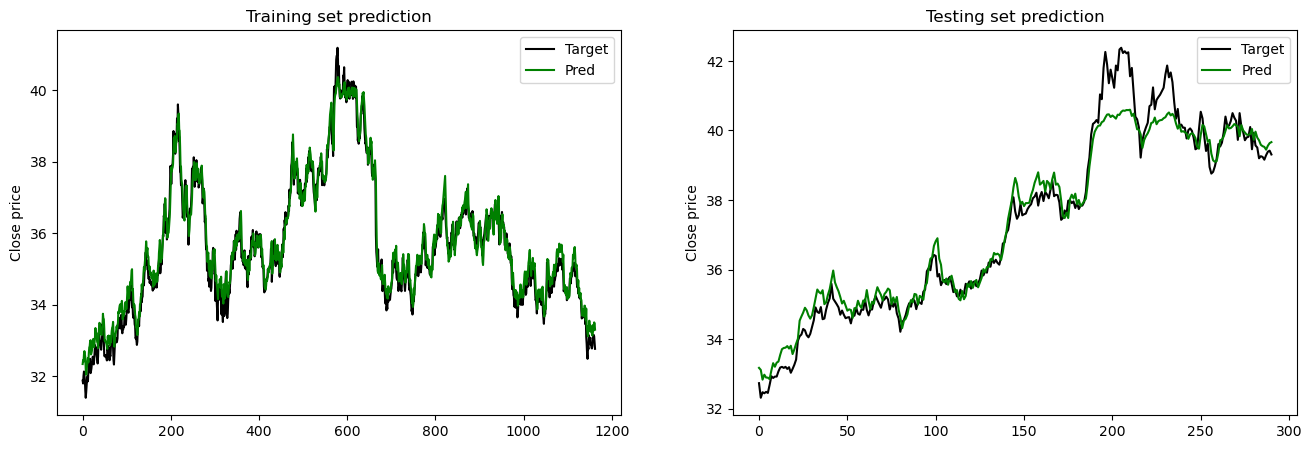

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(y_train, color = 'black', label = 'Target')
ax[0].plot(y_pred_train, color = 'green', label = 'Pred')
ax[0].set_title('Training set prediction')
ax[0].set_ylabel('Close price')
ax[0].legend()

ax[1].plot(y_test, color = 'black', label = 'Target')
ax[1].plot(y_pred_test, color = 'green', label = 'Pred')
ax[1].set_title('Testing set prediction')
ax[1].set_ylabel('Close price')
ax[1].legend()
plt.show()

In [17]:
def buy_sell_threshold(current_price, predicted_price, threshold):
    # The backtest framework skips the first iteration
    Buy, Sell = [np.nan], [np.nan]

    for i in range(len(predicted_price)-1):
        if predicted_price[i] / current_price[i] - 1 > threshold:
            Buy.append(current_price[i])
            Sell.append(np.nan)
        elif predicted_price[i] / current_price[i] - 1 < - threshold:
            Sell.append(current_price[i])
            Buy.append(np.nan)
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
    return Buy, Sell

def generate_dynamic_signals(current_price, predictions, threshold=0.01):
    # Assuming predictions are normalized and centered around 0
    signals = np.zeros(len(predictions))

    for i in range(1, len(predictions)):
        change_percent = (predictions[i] / current_price[i] * 100) -1

        # if change_percent > threshold:
        if abs(change_percent) > threshold:
            # Signal strength is proportional to the change percent
            signals[i] = np.tanh(change_percent)
        else:
            signals[i] = 0
    
    return signals


In [18]:
strategy_data = pd.DataFrame(index=data.index)
strategy_data['Close'] = data['Close']
strategy_data['Date'] = data['Date']
strategy_data['Predictions'] = np.nan
strategy_data['Daily_EFFR'] = data['Daily_EFFR']
strategy_data['Daily_excess_return'] = data['Daily_excess_return'] 

strategy_data.iloc[time_step: time_step+len(y_pred_train), strategy_data.columns.get_loc('Predictions')] = y_pred_train.flatten()
strategy_data.iloc[len(X_train)+time_step:len(X_train)+time_step+len(y_pred_test),strategy_data.columns.get_loc('Predictions')] = y_pred_test.flatten()

strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return
0,31.805000,2014-03-14,NaN,0.000003,0.000311
1,31.590000,2014-03-17,NaN,0.000003,-0.006763
2,31.665001,2014-03-18,NaN,0.000003,0.002371
3,31.440001,2014-03-19,NaN,0.000003,-0.007109
4,31.379999,2014-03-20,NaN,0.000003,-0.001912
...,...,...,...,...,...
1455,39.160000,2019-12-23,39.528004,0.000062,-0.002100
1456,39.290001,2019-12-24,39.448524,0.000062,0.003258
1457,39.389999,2019-12-26,39.562721,0.000062,0.002484
1458,39.419998,2019-12-27,39.637440,0.000062,0.000700


In [19]:
strategy_data['Buy_Signal_Price'], strategy_data['Sell_Signal_Price'] = buy_sell_threshold(current_price = strategy_data['Close'], 
                                                                                           predicted_price = strategy_data['Predictions'], 
                                                                                           threshold = 0.02)
buy_signal = np.where(strategy_data['Buy_Signal_Price'] > 0, 1, 0)
sell_signal = np.where(strategy_data['Sell_Signal_Price'] > 0, -1, 0)
signal = buy_signal + sell_signal
strategy_data['Signal'] = signal
strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return,Buy_Signal_Price,Sell_Signal_Price,Signal
0,31.805000,2014-03-14,NaN,0.000003,0.000311,NaN,NaN,0
1,31.590000,2014-03-17,NaN,0.000003,-0.006763,NaN,NaN,0
2,31.665001,2014-03-18,NaN,0.000003,0.002371,NaN,NaN,0
3,31.440001,2014-03-19,NaN,0.000003,-0.007109,NaN,NaN,0
4,31.379999,2014-03-20,NaN,0.000003,-0.001912,NaN,NaN,0
...,...,...,...,...,...,...,...,...
1455,39.160000,2019-12-23,39.528004,0.000062,-0.002100,NaN,NaN,0
1456,39.290001,2019-12-24,39.448524,0.000062,0.003258,NaN,NaN,0
1457,39.389999,2019-12-26,39.562721,0.000062,0.002484,NaN,NaN,0
1458,39.419998,2019-12-27,39.637440,0.000062,0.000700,NaN,NaN,0


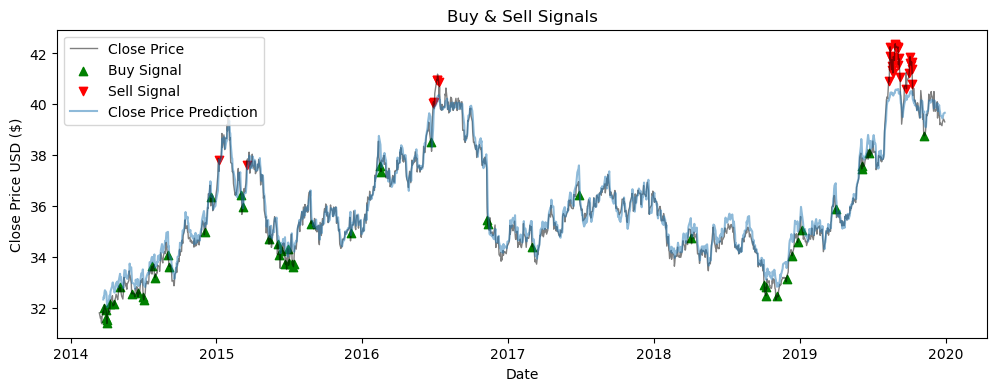

In [20]:
plot_signals(strategy_data=strategy_data, signal = signal)
plt.plot(strategy_data['Date'], strategy_data['Predictions'], label='Close Price Prediction', alpha=0.5)
plt.legend()

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


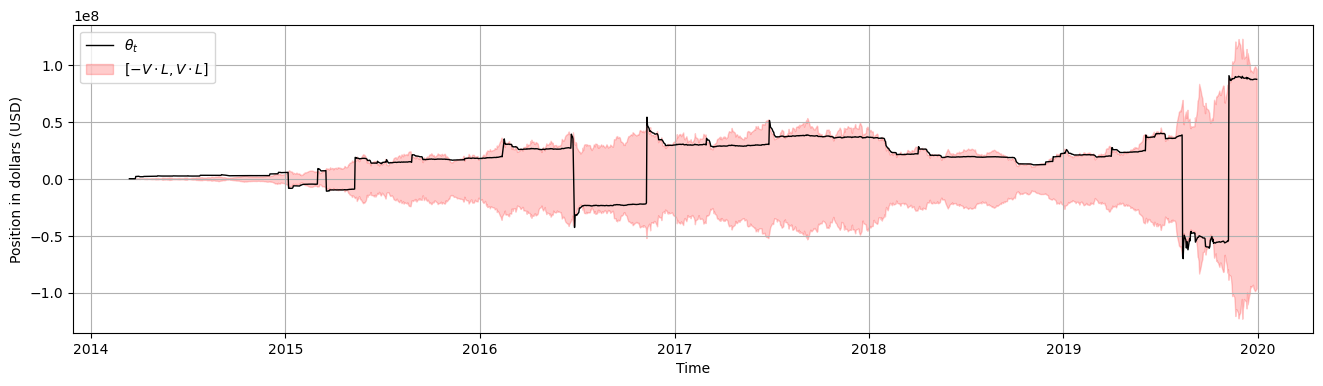

In [21]:
result = compute_position_value(df = strategy_data, 
                                signal = strategy_data['Signal'], 
                                initial_capital = INITIAL_CAP, 
                                max_leverage = LEVERAGE, 
                                reduced_leverage_shorting = False,
                                hold_at_signal_0 = True)
plot_position(strategy_data['Date'], result['theta'], result['Vtot'], LEVERAGE)


/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


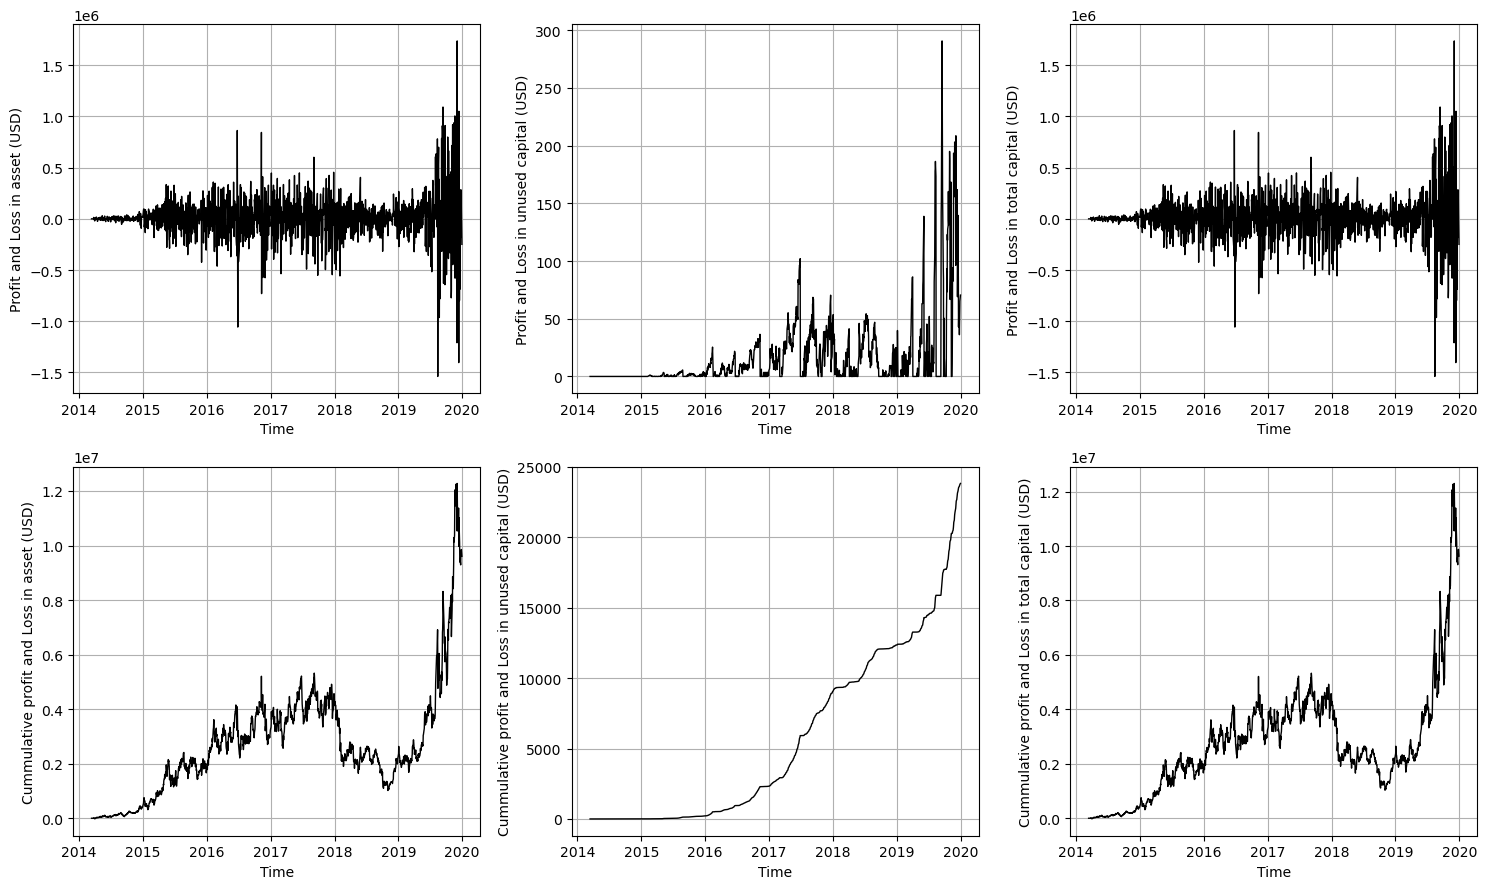

In [22]:
plot_PnL(strategy_data['Date'], result['dV'], result['dVcap'], result['dVtot'])

In [23]:
strategy_data

,Close,Date,Predictions,Daily_EFFR,Daily_excess_return,Buy_Signal_Price,Sell_Signal_Price,Signal
0,31.805000,2014-03-14,NaN,0.000003,0.000311,NaN,NaN,0
1,31.590000,2014-03-17,NaN,0.000003,-0.006763,NaN,NaN,0
2,31.665001,2014-03-18,NaN,0.000003,0.002371,NaN,NaN,0
3,31.440001,2014-03-19,NaN,0.000003,-0.007109,NaN,NaN,0
4,31.379999,2014-03-20,NaN,0.000003,-0.001912,NaN,NaN,0
...,...,...,...,...,...,...,...,...
1455,39.160000,2019-12-23,39.528004,0.000062,-0.002100,NaN,NaN,0
1456,39.290001,2019-12-24,39.448524,0.000062,0.003258,NaN,NaN,0
1457,39.389999,2019-12-26,39.562721,0.000062,0.002484,NaN,NaN,0
1458,39.419998,2019-12-27,39.637440,0.000062,0.000700,NaN,NaN,0


In [24]:
np.cumsum(np.diff(result['Vtot']))[-1]

9628713.686075345

## 3. Get average model performance

In [25]:
cum_pnl = []
cum_pnl_hold = []
best_profit = -np.inf
for iteration in range(5):
    model = train_lstm(seed = iteration)
    model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    strategy_data.iloc[time_step: time_step+len(y_pred_train), strategy_data.columns.get_loc('Predictions')] = y_pred_train.flatten()
    strategy_data.iloc[len(X_train)+time_step:len(X_train)+time_step+len(y_pred_test),strategy_data.columns.get_loc('Predictions')] = y_pred_test.flatten()
    strategy_data['Buy_Signal_Price'], strategy_data['Sell_Signal_Price'] = buy_sell_threshold(strategy_data['Close'], strategy_data['Predictions'], 0.02)
    buy_signal = np.where(strategy_data['Buy_Signal_Price'] > 0, 1, 0)
    sell_signal = np.where(strategy_data['Sell_Signal_Price'] > 0, -1, 0)
    signal = buy_signal + sell_signal
    strategy_data['Signal'] = signal
    result = compute_position_value(df = strategy_data, 
                                signal = strategy_data['Signal'], 
                                initial_capital = INITIAL_CAP, 
                                max_leverage = LEVERAGE, 
                                reduced_leverage_shorting = False,
                                hold_at_signal_0 = False)
    
    result_hold = compute_position_value(df = strategy_data, 
                            signal = strategy_data['Signal'], 
                            initial_capital = INITIAL_CAP, 
                            max_leverage = LEVERAGE, 
                            reduced_leverage_shorting = False,
                            hold_at_signal_0 = True)
    
    pnl = np.cumsum(np.diff(result['Vtot']))[-1]
    pnl_hold = np.cumsum(np.diff(result_hold['Vtot']))[-1]
    cum_pnl.append(pnl)
    cum_pnl_hold.append(pnl_hold)
    
    # if pnl > best_profit:
    #     best_profit = pnl
    #     print(f'Model {iteration} achieves cumulative profit of {best_profit}')
    #     model.save(f'models/lstm_iteration_{iteration}.h5')
        
    # if pnl_hold > best_profit:
    #     best_profit = pnl_hold
    #     print(f'Model {iteration} achieves cumulative profit of {best_profit}')
    #     model.save(f'models/lstm_iteration_{iteration}_hold.h5')
    
        
    

Epoch 1/30


2024-03-14 00:01:24.592396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:01:24.857848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:01:24.982293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:01:25.232350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:01:25.513262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 468.9802

2024-03-14 00:01:27.827085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:01:27.918345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:01:28.022555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 6s 38ms/step - loss: 468.9802 - val_loss: 10.3503
Epoch 2/30
70/70 [==============================] - 2s 22ms/step - loss: 5.6235 - val_loss: 3.1725
Epoch 3/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5633 - val_loss: 2.8625
Epoch 4/30
70/70 [==============================] - 2s 23ms/step - loss: 3.5606 - val_loss: 3.2951
Epoch 5/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5818 - val_loss: 3.2635
Epoch 6/30
70/70 [==============================] - 2s 23ms/step - loss: 3.5765 - val_loss: 3.4792
Epoch 7/30
70/70 [==============================] - 2s 23ms/step - loss: 3.5673 - val_loss: 3.5378
Epoch 8/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5363 - val_loss: 2.9263
Epoch 9/30
70/70 [==============================] - 2s 23ms/step - loss: 3.4832 - val_loss: 3.1860
Epoch 10/30
70/70 [==============================] - 2s 22ms/step - loss: 3.2560 - val_loss: 1.9628
Epoch 11/30
70/70

2024-03-14 00:02:13.747577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:02:13.834939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:02:13.933778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 11ms/step
Epoch 1/30


2024-03-14 00:02:16.881200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:02:17.138469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:02:17.259412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:02:17.450351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:02:17.656551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 460.8309

2024-03-14 00:02:20.039249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:02:20.133483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:02:20.245493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 6s 39ms/step - loss: 460.8309 - val_loss: 0.8896
Epoch 2/30
70/70 [==============================] - 2s 23ms/step - loss: 3.9194 - val_loss: 2.4713
Epoch 3/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5772 - val_loss: 2.9046
Epoch 4/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5739 - val_loss: 3.0069
Epoch 5/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5753 - val_loss: 3.0867
Epoch 6/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5694 - val_loss: 3.3463
Epoch 7/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5648 - val_loss: 3.0479
Epoch 8/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5644 - val_loss: 2.8634
Epoch 9/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5577 - val_loss: 3.2465
Epoch 10/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5248 - val_loss: 3.2735
Epoch 11/30
70/70 

2024-03-14 00:03:05.659341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:03:05.747634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:03:05.855820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 9ms/step
Epoch 1/30


2024-03-14 00:03:08.833070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:03:09.129326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:03:09.240335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:03:09.415589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:03:09.632585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 427.6169

2024-03-14 00:03:12.090407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:03:12.187446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:03:12.319297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 6s 41ms/step - loss: 427.6169 - val_loss: 0.6364
Epoch 2/30
70/70 [==============================] - 2s 23ms/step - loss: 3.8211 - val_loss: 2.6456
Epoch 3/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5748 - val_loss: 3.0842
Epoch 4/30
70/70 [==============================] - 2s 23ms/step - loss: 3.5769 - val_loss: 2.8227
Epoch 5/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5696 - val_loss: 2.9408
Epoch 6/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5590 - val_loss: 3.3726
Epoch 7/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5728 - val_loss: 2.7086
Epoch 8/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5633 - val_loss: 2.8544
Epoch 9/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5331 - val_loss: 2.5080
Epoch 10/30
70/70 [==============================] - 2s 22ms/step - loss: 3.2977 - val_loss: 1.6758
Epoch 11/30
70/70 

2024-03-14 00:04:01.553232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:04:01.641381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 7/10 [====================>.........] - ETA: 0s

2024-03-14 00:04:01.755752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 9ms/step
Epoch 1/30


2024-03-14 00:04:04.690888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:04:04.943926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:04:05.073025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:04:05.267996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:04:05.515991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 540.4340

2024-03-14 00:04:07.883062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:04:07.974983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:04:08.110879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 6s 39ms/step - loss: 540.4340 - val_loss: 9.4638
Epoch 2/30
70/70 [==============================] - 2s 22ms/step - loss: 5.1548 - val_loss: 3.0764
Epoch 3/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5657 - val_loss: 2.4998
Epoch 4/30
70/70 [==============================] - 2s 23ms/step - loss: 3.5695 - val_loss: 2.8915
Epoch 5/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5718 - val_loss: 2.5169
Epoch 6/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5864 - val_loss: 2.5550
Epoch 7/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5860 - val_loss: 2.8181
Epoch 8/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5797 - val_loss: 2.8106
Epoch 9/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5698 - val_loss: 3.1344
Epoch 10/30
70/70 [==============================] - 2s 22ms/step - loss: 3.5674 - val_loss: 2.4635
Epoch 11/30
70/70 

2024-03-14 00:04:56.344400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:04:56.447534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 10s

2024-03-14 00:04:56.587925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 10ms/step
Epoch 1/30


2024-03-14 00:05:00.107127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:05:00.368834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:05:00.487942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:05:00.710984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:05:00.967181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 394.7668

2024-03-14 00:05:03.901384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:05:03.998206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:05:04.136396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 7s 49ms/step - loss: 394.7668 - val_loss: 3.9690
Epoch 2/30
70/70 [==============================] - 2s 25ms/step - loss: 3.7922 - val_loss: 2.7946
Epoch 3/30
70/70 [==============================] - 2s 25ms/step - loss: 3.5633 - val_loss: 2.6750
Epoch 4/30
70/70 [==============================] - 2s 23ms/step - loss: 3.5757 - val_loss: 3.1542
Epoch 5/30
70/70 [==============================] - 2s 24ms/step - loss: 3.6056 - val_loss: 3.0010
Epoch 6/30
70/70 [==============================] - 2s 25ms/step - loss: 3.5809 - val_loss: 3.2297
Epoch 7/30
70/70 [==============================] - 2s 24ms/step - loss: 3.5912 - val_loss: 3.0003
Epoch 8/30
70/70 [==============================] - 2s 24ms/step - loss: 3.5957 - val_loss: 3.1899
Epoch 9/30
70/70 [==============================] - 2s 24ms/step - loss: 3.6081 - val_loss: 2.0940
Epoch 10/30
70/70 [==============================] - 2s 23ms/step - loss: 3.5248 - val_loss: 3.7117
Epoch 11/30
70/70 

2024-03-14 00:05:51.020213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-14 00:05:51.110915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 7/10 [====================>.........] - ETA: 0s

2024-03-14 00:05:51.247156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 9ms/step


In [26]:
# print(f'Cumulative profit: {cum_pml}')
# print(f'Cumulative profit with reduced shorting leverage: {cum_pml_hold}')

In [27]:
# print(f'Mean cumulative profit: {np.mean(cum_pml):3f}')
# print(f'Mean cumulative profit with holding: {np.mean(cum_pml_hold):3f}')

In [28]:
cum_pnl_hold

[-196560.4260734579,
 5450228.962154946,
 2403473.5684912666,
 -80556.24396587265,
 1690459.0641844745]